In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, classification_report , roc_curve, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample 
from sklearn.naive_bayes import GaussianNB

In [4]:
# set matplotlib defaults
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (15,6)
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rc('figure', titlesize=18)
plt.style.use('seaborn-darkgrid')

In [48]:
data = pd.read_csv("../data/dataset_2019_with_negatives.csv")

In [49]:
data = data.drop(columns=['year', 'precipAccumulation'])

In [50]:
data.head()

,x,y,timestamp,date,month,day,day_of_year,day_of_week,hour,address,...,humidity,windSpeed,cloudCover,uvIndex,visibility,windBearing,windGust,pressure,precipType,ozone
0,-74.134363,4.579297,2019-01-11 14:20:00,2019-01-11,1,11,11,4,14,KR 26-CL 52B S 2,...,0.93,1.66,0.89,4.0,13.489,167.0,1.66,1018.0,rain,239.8
1,-74.048819,4.665144,2019-01-11 11:30:00,2019-01-11,1,11,11,4,11,CL 84-KR 8 2,...,0.97,1.11,0.83,0.0,12.254,128.0,1.15,1017.2,rain,240.5
2,-74.173301,4.615589,2019-01-11 23:20:00,2019-01-11,1,11,11,4,23,KR 80-CL 53A S 2,...,0.95,1.65,0.81,0.0,6.814,10.0,2.07,1014.8,rain,237.9
3,-74.025068,4.725288,2019-01-11 06:30:00,2019-01-11,1,11,11,4,6,KR 7-CL 150 2,...,0.88,0.97,0.90,0.0,15.389,41.0,0.99,1017.1,rain,242.7
4,-74.044628,4.752517,2019-01-11 06:00:00,2019-01-11 00:00:00,1,11,11,4,6,CL 172-KR 22A 2,...,0.88,0.97,0.90,0.0,15.389,41.0,0.99,1017.1,rain,242.7


In [20]:
data = pd.get_dummies(data, columns=['summary'])

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58133 entries, 0 to 58132
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   x                            58133 non-null  float64
 1   y                            58133 non-null  float64
 2   timestamp                    58133 non-null  object 
 3   date                         58133 non-null  object 
 4   month                        58133 non-null  int64  
 5   day                          58133 non-null  int64  
 6   day_of_year                  58133 non-null  int64  
 7   day_of_week                  58133 non-null  int64  
 8   hour                         58133 non-null  int64  
 9   address                      58133 non-null  object 
 10  severity                     29067 non-null  object 
 11  accident_type                29067 non-null  object 
 12  severity_numeric             29067 non-null  float64
 13  borough         

In [22]:
corr = data.corr()
c1 = corr.abs().unstack().round(3)
c1<1
c1[(c1<1) & (c1> 0.65)].sort_values(ascending = False)

apparentTemperature          temperature                    0.998
temperature                  apparentTemperature            0.998
month                        day_of_year                    0.996
day_of_year                  month                          0.996
temperature                  uvIndex                        0.833
uvIndex                      temperature                    0.833
windSpeed                    windGust                       0.826
windGust                     windSpeed                      0.826
uvIndex                      apparentTemperature            0.824
apparentTemperature          uvIndex                        0.824
precipProbability            precipIntensity                0.783
precipIntensity              precipProbability              0.783
temperature                  hour                           0.694
hour                         temperature                    0.694
apparentTemperature          hour                           0.688
hour      

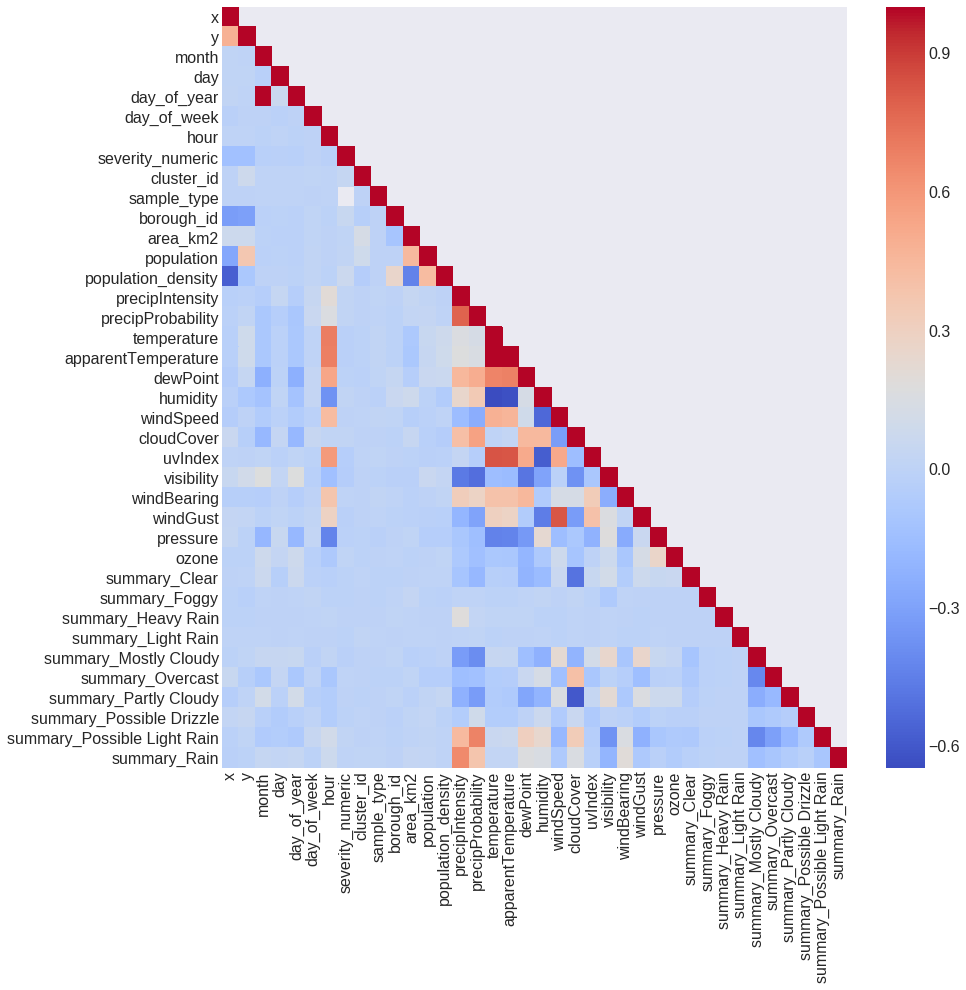

In [23]:
plt.figure(figsize=(14,14))
sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)), cmap='coolwarm')
plt.show()

## Useful Functions

In [57]:
def get_df(columns):
    return data[columns]

In [58]:
def separate_classes(df):
    return df[df.sample_type==0], df[df.sample_type==1]

In [59]:
def resample_df(resample_type, df_majority, df_minority):
    if resample_type == 'up':
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, replace=True, n_samples=df_majority.shape[0])        
        # Combine majority class with upsampled minority class
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])
        
        return df_upsampled

    if resample_type == 'down':
        # Upsample minority class
        df_majority_undersampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0])        
        # Combine majority class with upsampled minority class
        df_undersampled = pd.concat([df_minority, df_majority_undersampled])
        
        return df_undersampled 

In [60]:
def train_test_df(df, columns):
    cols = columns
    cols.remove('sample_type')
    X = df[columns]
    y = df.sample_type
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    return X_train, X_test, y_train, y_test  

In [61]:
def model_fit_predict(X_train, X_test, y_train, y_test):
    categories = ['non-accident', 'accident']
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring= 'f1_weighted', n_jobs=-1)
    print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

    y_pred = clf.predict(X_test)
    print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred, y_test)))
    print(classification_report(y_test, y_pred,target_names=categories))

    metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
    scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
    cv = KFold(n_splits=10)
    scv = StratifiedKFold(n_splits=10)
    for metric in metric_names:
        score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
        score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
        scores_df.loc[metric] = [score1, score2]
    print(scores_df)
    y_pred_proba = clf.predict_proba(X_test)[:,1]

    return clf, y_pred, y_pred_proba


In [92]:
def model_plot(y_test, y_pred, y_pred_proba, model_name):
    categories = ['non-accident', 'accident']
    gs = mpl.gridspec.GridSpec(2, 2)

    plt.figure(figsize=(14,10))
    ax = plt.subplot(gs[0, 0]) # row 0, col 0
    labels = [0,1]
    cnf_mx = confusion_matrix(y_test,y_pred,labels=labels)
    ax1 = sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Confusion matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    ax = plt.subplot(gs[0, 1]) # row 0, col 1
    row_sums = cnf_mx.sum(axis=1, keepdims=True)
    norm_cnf_mx = cnf_mx / row_sums
    np.fill_diagonal(norm_cnf_mx, 0)
    ax2 = sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".4%")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Error matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')

    ax = plt.subplot(gs[1, :]) # row 1, span all columns
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    # Display plot for AUC curve
    ax3 = plt.plot(fpr,tpr,label= f"{model_name}, auc={round(auc,4)}")
    ax3 = plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(fontsize=14)
    plt.title(f"ROC cuve: {model_name}", fontsize= 18)
    plt.tight_layout()
    plt.show()

In [63]:
def generate_cyclical_variables(df, column, period):
    if df[column].min() != 0:
        df[f'{column}_sin'] = np.sin((df[column] - 1)*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column] - 1)*(2.*np.pi/period))
    else:
        df[f'{column}_sin'] = np.sin((df[column])*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column])*(2.*np.pi/period))

    return df

In [64]:
generate_cyclical_variables(data, 'hour', 24)
generate_cyclical_variables(data, 'day_of_week', 7)
generate_cyclical_variables(data, 'month', 12)
generate_cyclical_variables(data, 'day_of_year', 365)

,x,y,timestamp,date,month,day,day_of_year,day_of_week,hour,address,...,precipType,ozone,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,-74.134363,4.579297,2019-01-11 14:20:00,2019-01-11,1,11,11,4,14,KR 26-CL 52B S 2,...,rain,239.8,-0.500000,-8.660254e-01,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
1,-74.048819,4.665144,2019-01-11 11:30:00,2019-01-11,1,11,11,4,11,CL 84-KR 8 2,...,rain,240.5,0.258819,-9.659258e-01,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
2,-74.173301,4.615589,2019-01-11 23:20:00,2019-01-11,1,11,11,4,23,KR 80-CL 53A S 2,...,rain,237.9,-0.258819,9.659258e-01,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
3,-74.025068,4.725288,2019-01-11 06:30:00,2019-01-11,1,11,11,4,6,KR 7-CL 150 2,...,rain,242.7,1.000000,6.123234e-17,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
4,-74.044628,4.752517,2019-01-11 06:00:00,2019-01-11 00:00:00,1,11,11,4,6,CL 172-KR 22A 2,...,rain,242.7,1.000000,6.123234e-17,-0.433884,-0.900969,0.0,1.000000e+00,0.171293,0.985220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58128,-74.135687,4.580801,2019-12-03 16:00:00,2019-12-03 00:00:00,12,3,337,1,16,KR 28-DG 52B S 2,...,rain,240.9,-0.866025,-5.000000e-01,0.781831,0.623490,-0.5,8.660254e-01,-0.478734,0.877960
58129,-74.084275,4.590371,2019-01-12 04:00:00,2019-01-12 00:00:00,1,12,12,5,4,KR 10-CL 1B 02,...,rain,238.6,0.866025,5.000000e-01,-0.974928,-0.222521,0.0,1.000000e+00,0.188227,0.982126
58130,-74.097752,4.619585,2019-10-04 16:00:00,2019-10-04 00:00:00,10,4,277,4,16,CL 13-KR 37 35,...,rain,259.2,-0.866025,-5.000000e-01,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.999250,0.038722
58131,-74.174217,4.576242,2019-12-20 19:00:00,2019-12-20 00:00:00,12,20,354,4,19,KR 75-CL 75D S 02,...,rain,232.8,-0.965926,2.588190e-01,-0.433884,-0.900969,-0.5,8.660254e-01,-0.205104,0.978740


## Model 0

### All Variables. Unbalanced Classes

In [52]:
data.columns

Index(['x', 'y', 'timestamp', 'date', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'borough', 'cluster_id', 'sample_type',
       'borough_id', 'area_km2', 'population', 'population_density',
       'timestamp_darksky', 'summary', 'icon', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'pressure', 'precipType', 'ozone',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

In [86]:
feature_columns_model_0 = ['x', 'y',
       'area_km2', 'population', 'population_density', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'pressure', 'ozone',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos','sample_type']

In [87]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_df(data, feature_columns_model_0)

In [90]:
clf0, y_pred_0, y_pred_proba_0 = model_fit_predict(X_train_0, X_test_0, y_train_0, y_test_0)

Weigthed F1 score: 0.50 (+/- 0.026 )
Cohen kappa score 0.0163
              precision    recall  f1-score   support

non-accident       0.51      0.64      0.57      9613
    accident       0.51      0.38      0.43      9571

    accuracy                           0.51     19184
   macro avg       0.51      0.51      0.50     19184
weighted avg       0.51      0.51      0.50     19184

                  Random-CV Stratified-CV
f1                 0.431031      0.430395
roc_auc            0.507655      0.507912
average_precision  0.507579       0.50769
accuracy           0.506226      0.506431
precision           0.50917      0.508666
recall             0.376186      0.375051


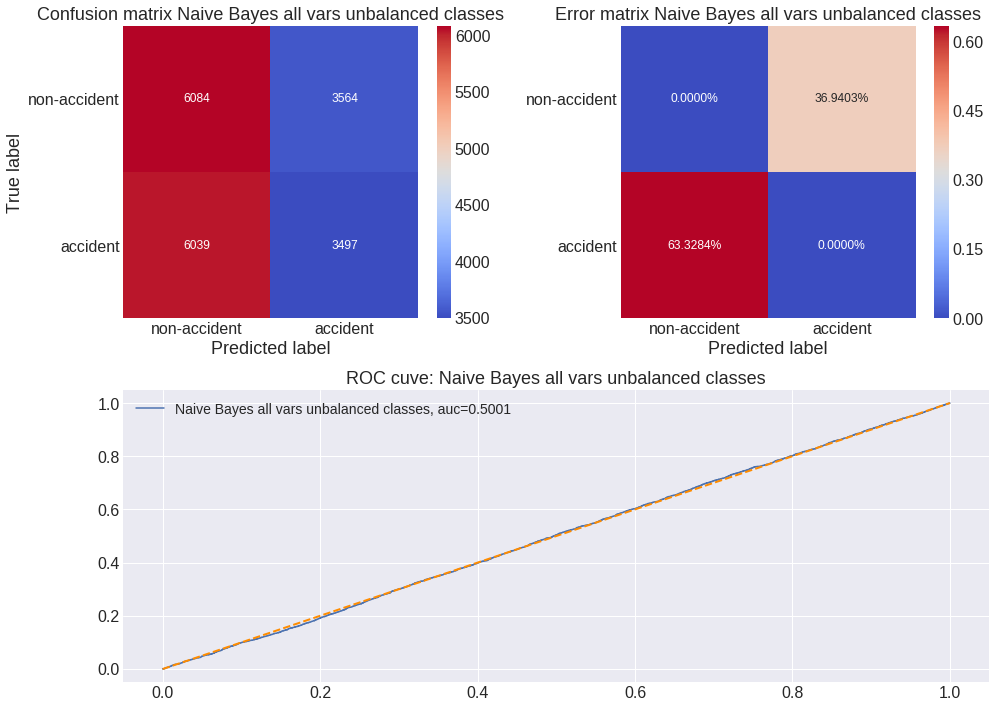

In [95]:
model_plot(y_test, y_pred_0, y_pred_proba_0, 'Naive Bayes all vars unbalanced classes')

## First model

###  All variables. Balanced Classes

In [345]:
feature_columns_model_1 = ['x', 'y', 'month', 'day', 'day_of_year', 'hour',
       'cluster_id', 'area_km2', 'population',
       'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'windGust', 'ozone', 'borough_id', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain', 'sample_type']

In [313]:
df_majority_1, df_minority_1 = separate_classes(get_df(feature_columns_model_1))

### Upsampling

In [314]:
df_upsampled_1 = resample_df('up', df_majority_1, df_minority_1)
X_train, X_test, y_train, y_test = train_test_df(df_upsampled_1, feature_columns_model_1)

In [315]:
clf1, y_pred_1, y_pred_proba_1 = model_fit_predict(X_train, X_test, y_train, y_test)

Weigthed F1 score: 0.50 (+/- 0.009 )
Cohen kappa score -0.0060
              precision    recall  f1-score   support

non-accident       0.50      0.60      0.55     48011
    accident       0.50      0.39      0.44     47888

    accuracy                           0.50     95899
   macro avg       0.50      0.50      0.49     95899
weighted avg       0.50      0.50      0.49     95899

                  Random-CV Stratified-CV
f1                 0.442386      0.443491
roc_auc            0.504709      0.504747
average_precision  0.503472      0.503535
accuracy           0.503166      0.503531
precision          0.504579      0.504845
recall             0.394711      0.396179


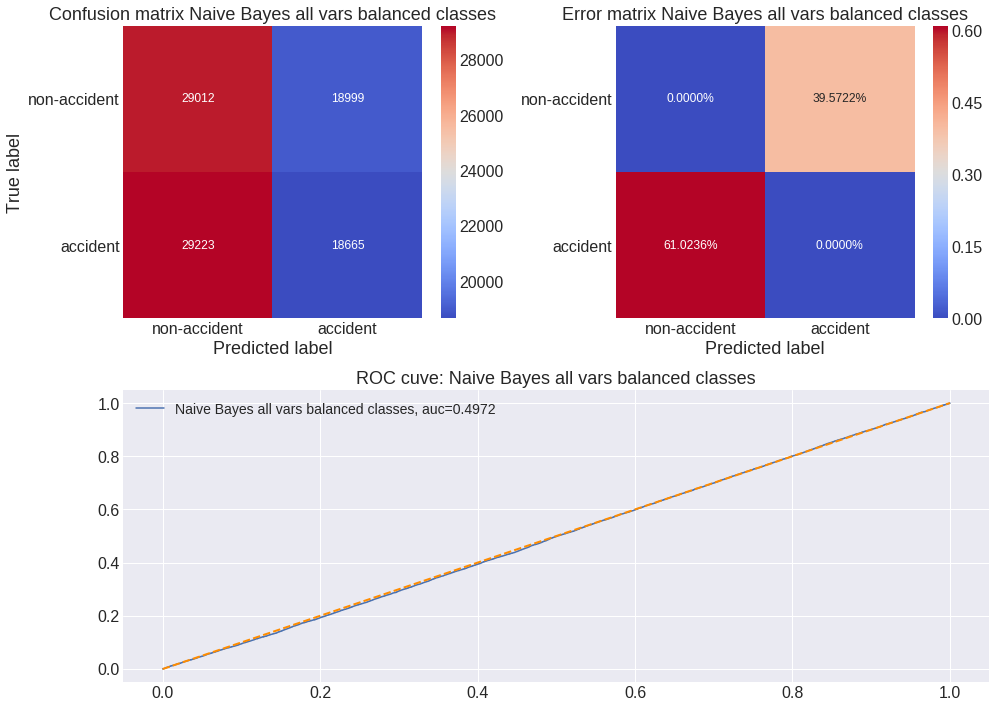

In [316]:
model_plot(y_test, y_pred_1, y_pred_proba_1, 'Naive Bayes all vars balanced classes')

In [346]:
df_downsampled_1 = resample_df('down', df_majority_1, df_minority_1)
X_train, X_test, y_train, y_test = train_test_df(df_downsampled_1, feature_columns_model_1)

In [347]:
clf1, y_pred_12, y_pred_proba_12 = model_fit_predict(X_train, X_test, y_train, y_test)

Weigthed F1 score: 0.48 (+/- 0.024 )
Cohen kappa score -0.0048
              precision    recall  f1-score   support

non-accident       0.50      0.70      0.58      9578
    accident       0.50      0.30      0.37      9597

    accuracy                           0.50     19175
   macro avg       0.50      0.50      0.48     19175
weighted avg       0.50      0.50      0.48     19175

                  Random-CV Stratified-CV
f1                 0.397125      0.398033
roc_auc            0.490183      0.490611
average_precision  0.495782      0.495907
accuracy           0.494387      0.495723
precision          0.492909      0.493555
recall             0.346495      0.342584


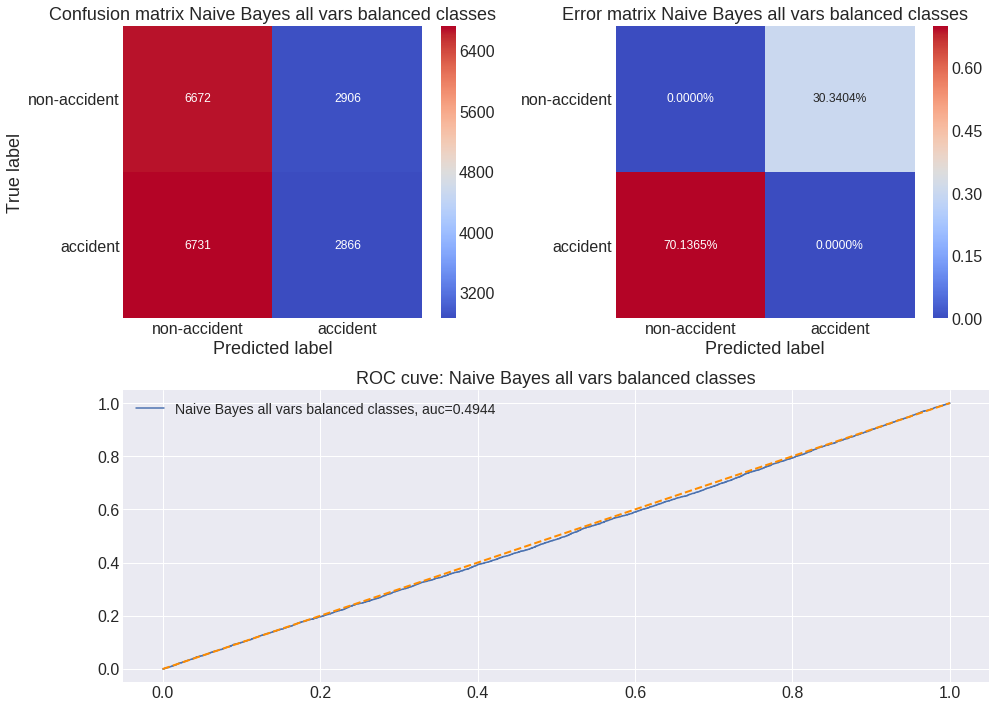

In [348]:
model_plot(y_test, y_pred_12, y_pred_proba_12, 'Naive Bayes all vars balanced classes')

## Second model

###  Numeric weather Covariates. Balanced classes

In [358]:
columns_model_2 = ['x', 'y', 'day_of_year', 'hour',
       'cluster_id','population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'dewPoint', 'humidity','windSpeed', 
       'cloudCover', 'visibility', 'pressure', 'borough_id', 'sample_type']
data.columns 

Index(['x', 'y', 'timestamp', 'date', 'day_of_year', 'month', 'day', 'hour',
       'address', 'severity', 'accident_type', 'severity_numeric', 'borough',
       'cluster_id', 'sample_type', 'area_km2', 'population',
       'population_density', 'timestamp_darksky', 'icon', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility', 'pressure', 'windGust', 'precipType', 'ozone',
       'borough_id', 'summary_Clear', 'summary_Foggy', 'summary_Heavy Rain',
       'summary_Light Rain', 'summary_Mostly Cloudy', 'summary_Overcast',
       'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain'],
      dtype='object')

In [357]:
feature_selection_1 = get_df(feature_columns_model_2)

KeyError: "['precipitation_probability_intesity'] not in index"

In [351]:
df_majority_1, df_minority_1 = separate_classes(feature_selection_1)

AttributeError: 'DataFrame' object has no attribute 'sample_type'

In [90]:
feature_selection_1

,x,y,day_of_year,hour,cluster_id,population_density,precipIntensity,precipProbability,temperature,dewPoint,humidity,windSpeed,cloudCover,visibility,pressure,borough_id,sample_type,precipitation_probability_intesity
0,-74.134363,4.579297,11,14,-1,20124.11,0.3083,0.22,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,1,0.067826
1,-74.139488,4.573233,11,14,586,20124.11,0.3083,0.22,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,0,0.067826
2,-74.135804,4.588874,11,17,-1,20124.11,1.6823,0.35,14.98,13.98,0.94,1.90,0.95,12.000,1016.3,6,1,0.588805
3,-74.123576,4.558440,11,17,275,20124.11,1.6823,0.35,14.98,13.98,0.94,1.90,0.95,12.000,1016.3,6,0,0.588805
4,-74.138016,4.566990,24,12,33,20124.11,0.1040,0.08,11.85,10.06,0.89,3.37,0.67,15.142,1016.2,6,1,0.008320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174349,-74.364048,3.985513,5,13,-1,8.36,0.0906,0.08,5.69,4.32,0.91,3.04,0.44,13.723,1019.8,20,0,0.007248
174350,-74.364048,3.985513,232,13,-1,8.36,0.2862,0.12,5.61,5.39,0.98,2.17,0.75,6.701,1020.7,20,0,0.034344
174351,-74.364001,3.985578,149,6,-1,8.36,0.5873,0.17,6.03,6.03,1.00,1.64,0.99,7.132,1018.0,20,0,0.099841
174352,-74.364001,3.985578,212,6,-1,8.36,0.0072,0.08,3.99,3.62,0.97,2.47,0.46,16.093,1018.9,20,0,0.000576


In [91]:
feature_selection_1 = feature_selection_1.drop(columns=['precipIntensity', 'precipProbability'])

In [92]:
feature_selection_1.head(2)

,x,y,day_of_year,hour,cluster_id,population_density,temperature,dewPoint,humidity,windSpeed,cloudCover,visibility,pressure,borough_id,sample_type,precipitation_probability_intesity
0,-74.134363,4.579297,11,14,-1,20124.11,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,1,0.067826
1,-74.139488,4.573233,11,14,586,20124.11,13.03,11.88,0.93,1.66,0.89,13.489,1018.0,6,0,0.067826


In [93]:
# Separate majority and minority classes
df_majority_fs_1 = feature_selection_1[feature_selection_1.sample_type==0]
df_minority_fs1 = feature_selection_1[feature_selection_1.sample_type==1]
print(df_majority_fs_1.shape, df_minority_fs1.shape)

(145301, 16) (29053, 16)


In [94]:
# Upsample minority class
df_minority_upsampled_fs1 = resample(df_minority_fs1, replace=True, n_samples=29053*5)
 
# Combine majority class with upsampled minority class
df_upsampled_fs1 = pd.concat([df_majority_fs_1, df_minority_upsampled_fs1])
 
# Display new class counts
df_upsampled_fs1.sample_type.value_counts()

0    145301
1    145265
Name: sample_type, dtype: int64

In [95]:
df_majority_fs_1.columns

Index(['x', 'y', 'day_of_year', 'hour', 'cluster_id', 'population_density',
       'temperature', 'dewPoint', 'humidity', 'windSpeed', 'cloudCover',
       'visibility', 'pressure', 'borough_id', 'sample_type',
       'precipitation_probability_intesity'],
      dtype='object')

In [98]:
feature_columns_model_2 = ['x', 'y', 'day_of_year', 'hour', 'cluster_id',
                            'population_density', 'temperature', 'dewPoint', 'humidity',
                            'windSpeed', 'cloudCover', 'visibility', 'pressure',
                            'borough_id', 'precipitation_probability_intesity']

In [99]:
X = df_upsampled_fs1[feature_columns_model_2]
y = df_upsampled_fs1.sample_type

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [101]:
categories = ['accident', 'non-accident']
clf3 = GaussianNB()
clf3.fit(X_train, y_train)
scores = cross_val_score(clf3, X_train, y_train, cv=10, scoring= 'f1_weighted', n_jobs=-1)
print('Weigthed F1 score: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

Weigthed F1 score: 0.49 (+/- 0.013 )


In [102]:
y_pred = clf3.predict(X_test)
print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred, y_test)))
print(classification_report(y_test, y_pred,target_names=categories))

Cohen kappa score 0.0003
              precision    recall  f1-score   support

    accident       0.50      0.62      0.55     47734
non-accident       0.50      0.38      0.43     48153

    accuracy                           0.50     95887
   macro avg       0.50      0.50      0.49     95887
weighted avg       0.50      0.50      0.49     95887



In [103]:
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
for metric in metric_names:
    score1 = cross_val_score(clf3, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
    score2 = cross_val_score(clf3, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
    scores_df.loc[metric] = [score1, score2]

In [104]:
scores_df

,Random-CV,Stratified-CV
f1,0.431082,0.433217
roc_auc,0.502204,0.502172
average_precision,0.499217,0.499173
accuracy,0.499864,0.500511
precision,0.499115,0.499345
recall,0.383815,0.385276


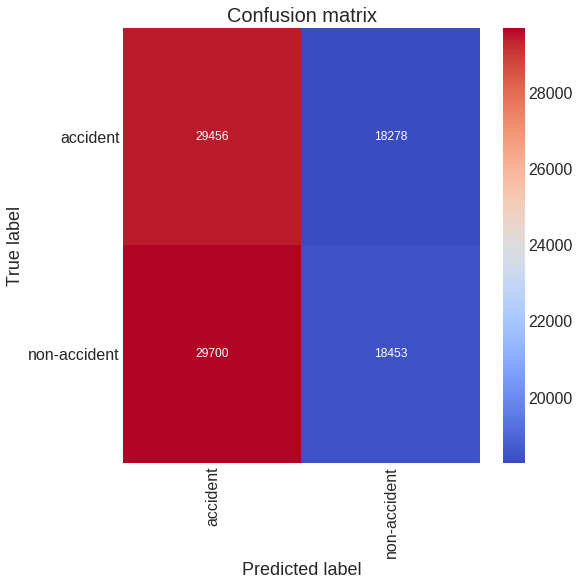

In [105]:
cnf_mx = confusion_matrix(y_test,y_pred,labels=y.unique())
plt.figure(figsize=(8,8))
sns.heatmap(cnf_mx, cmap='coolwarm',annot=True, fmt="d")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

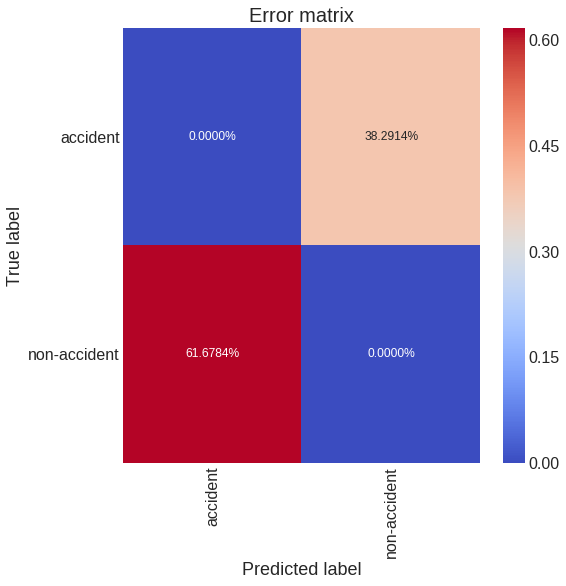

In [106]:
row_sums = cnf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = cnf_mx / row_sums
np.fill_diagonal(norm_cnf_mx, 0)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cnf_mx, cmap='coolwarm',annot=True, fmt=".4%")
plt.xticks([0.5,1.5],categories, rotation=90)
plt.yticks([0.5,1.5],categories, rotation=0)
plt.title('Error matrix', fontsize=20)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

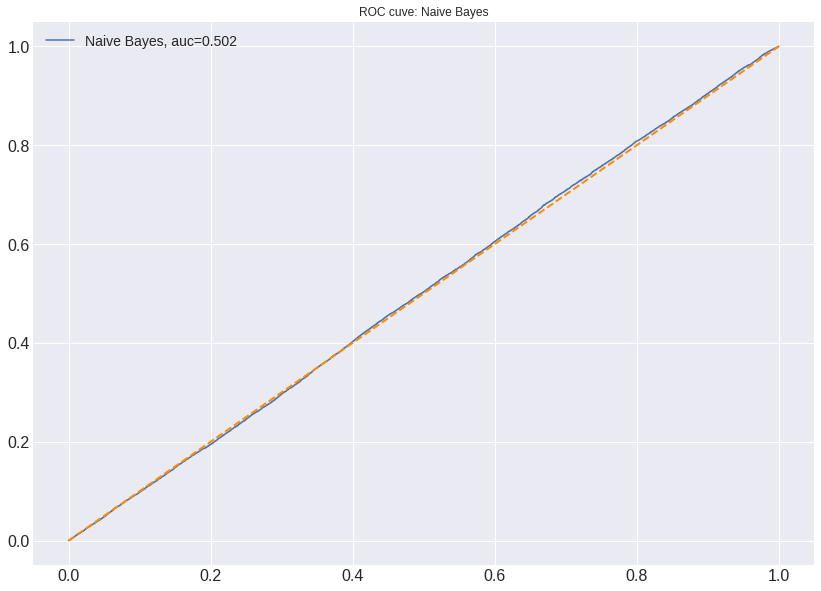

0.5023

In [107]:
roc_curve(clf3.predict_proba(X_test)[:,1], y_test, "Naive Bayes")

### Categorical weather covariates. Balanced Classes

In [180]:
columns_model_3 = ['x', 'y', 'day_of_year', 'hour',
       'cluster_id', 'population_density', 'borough_id', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain', 'sample_type']

Majority class size: (145301, 18) 
Minority class size: (29053, 18)


In [158]:
model21_df = resample_df('up', df_majority_fs_2, df_minority_fs2)

In [182]:
X_train, X_test, y_train, y_test = train_test_df(model21_df, columns_model_3)

In [219]:
clf4, y_pred4, y_pred_proba4 = model_fit_predict(X_train, X_test, y_train, y_test)

Weigthed F1 score: 0.50 (+/- 0.009 )
Cohen kappa score 0.0059
              precision    recall  f1-score   support

    accident       0.50      0.53      0.51     47930
non-accident       0.50      0.48      0.49     47969

    accuracy                           0.50     95899
   macro avg       0.50      0.50      0.50     95899
weighted avg       0.50      0.50      0.50     95899

                  Random-CV Stratified-CV
f1                 0.497342      0.496459
roc_auc            0.498759      0.498768
average_precision   0.50009      0.500056
accuracy            0.49953      0.499535
precision          0.499478      0.499412
recall             0.496131       0.49436


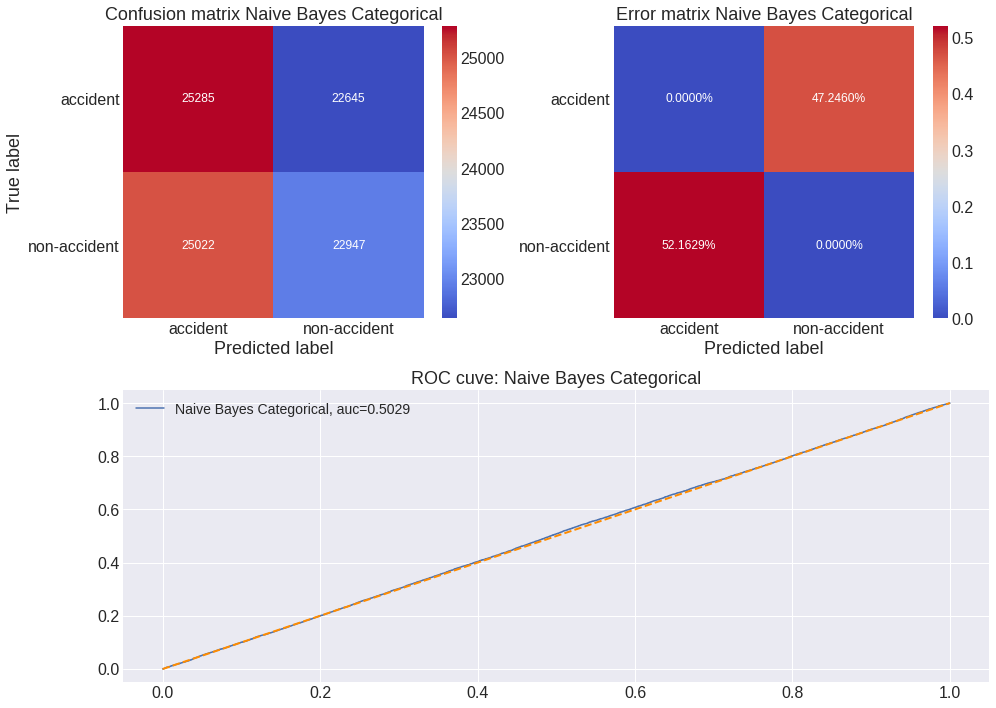

In [247]:
model_plot(y_test, y_pred4, y_pred_proba4,  'Naive Bayes Categorical')